# Zach's initial analysis

Work in progress

In [1]:
from pathlib import Path
from pydantic import BaseModel
import json
from typing import List, Dict

class ObjectLabel(BaseModel):
    name: str
    bounding_box: List[int]
    area: int

class ImageAnnotation(BaseModel):
    file_path: str
    object_labels: List[ObjectLabel]
    image_area: int

# Define paths
PROJECT_ROOT = Path('.').resolve().parent
PREPROCESSED_JSON_DIR = PROJECT_ROOT / "data" / "preprocessed_jsons"
PATH_TO_TRAIN_DATA = PREPROCESSED_JSON_DIR / "train.json"
PATH_TO_TEST_DATA = PREPROCESSED_JSON_DIR / "test.json"

# Load data
with open(PATH_TO_TRAIN_DATA) as f:
    train_data = [ImageAnnotation(**item) for item in json.load(f)]
    
with open(PATH_TO_TEST_DATA) as f:
    test_data = [ImageAnnotation(**item) for item in json.load(f)]


In [2]:
train_data[0].model_dump()

{'file_path': '2011_002212',
 'object_labels': [{'name': 'person',
   'bounding_box': [200, 75, 387, 343],
   'area': 50116},
  {'name': 'person', 'bounding_box': [71, 38, 359, 344], 'area': 88128}],
 'image_area': 187500}

In [3]:
import pandas as pd

# Create list to store all object labels
all_objects = []

# Process train data
for image in train_data:
    for obj in image.object_labels:
        all_objects.append({
            'file_path': image.file_path,
            'label_name': obj.name,
            'bbox_left': obj.bounding_box[0],
            'bbox_top': obj.bounding_box[1], 
            'bbox_right': obj.bounding_box[2],
            'bbox_bottom': obj.bounding_box[3],
            'object_area': obj.area,
            'image_area': image.image_area,
            'dataset': 'train'
        })

# Process test data        
for image in test_data:
    for obj in image.object_labels:
        all_objects.append({
            'file_path': image.file_path,
            'label_name': obj.name,
            'bbox_left': obj.bounding_box[0],
            'bbox_top': obj.bounding_box[1],
            'bbox_right': obj.bounding_box[2], 
            'bbox_bottom': obj.bounding_box[3],
            'object_area': obj.area,
            'image_area': image.image_area,
            'dataset': 'test'
        })

# Create dataframe
df_objects = pd.DataFrame(all_objects)

# Display first few rows and basic info
print("DataFrame Info:")
print(df_objects.info())
print("\nFirst few rows:")
display(df_objects.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33256 entries, 0 to 33255
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    33256 non-null  object
 1   label_name   33256 non-null  object
 2   bbox_left    33256 non-null  int64 
 3   bbox_top     33256 non-null  int64 
 4   bbox_right   33256 non-null  int64 
 5   bbox_bottom  33256 non-null  int64 
 6   object_area  33256 non-null  int64 
 7   image_area   33256 non-null  int64 
 8   dataset      33256 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.3+ MB
None

First few rows:


,file_path,label_name,bbox_left,bbox_top,bbox_right,bbox_bottom,object_area,image_area,dataset
0,2011_002212,person,200,75,387,343,50116,187500,train
1,2011_002212,person,71,38,359,344,88128,187500,train
2,2010_002413,bus,380,127,500,224,11640,178500,train
3,2010_002413,bus,273,137,339,179,2772,178500,train
4,2010_002413,bus,106,96,320,250,32956,178500,train


In [4]:
# Calculate statistics grouped by label
label_statistics = df_objects.groupby('label_name').agg(
    count=('object_area', 'count'),
    image_count=('file_path', 'nunique'),
    median_area=('object_area', 'median'),
    mean_area=('object_area', 'mean'),
    var_area=('object_area', 'var'),
    std_area=('object_area', 'std'),
    min_area=('object_area', 'min'),
    max_area=('object_area', 'max'),
    median_area_ratio=('object_area', lambda x: (x / df_objects.loc[x.index, 'image_area']).median()),
    mean_area_ratio=('object_area', lambda x: (x / df_objects.loc[x.index, 'image_area']).mean()),
    var_area_ratio=('object_area', lambda x: (x / df_objects.loc[x.index, 'image_area']).var()),
    std_area_ratio=('object_area', lambda x: (x / df_objects.loc[x.index, 'image_area']).std()),
    min_area_ratio=('object_area', lambda x: (x / df_objects.loc[x.index, 'image_area']).min()),
    max_area_ratio=('object_area', lambda x: (x / df_objects.loc[x.index, 'image_area']).max()),
)

# Display the statistics
print("Label Statistics:")
display(label_statistics)


Label Statistics:


,count,image_count,median_area,mean_area,var_area,std_area,min_area,max_area,median_area_ratio,mean_area_ratio,var_area_ratio,std_area_ratio,min_area_ratio,max_area_ratio
label_name,,,,,,,,,,,,,,
aeroplane,825,595,39852.0,49097.246061,2.180362e+09,46694.345044,44,191117,0.226914,0.287283,0.072769,0.269758,0.000264,0.995204
bicycle,711,507,24696.0,47508.917018,2.726797e+09,52218.740221,108,213323,0.137344,0.263388,0.081646,0.285738,0.000576,0.995473
bird,1036,662,14959.0,32713.649614,1.626422e+09,40328.923570,48,214722,0.081002,0.177691,0.045880,0.214195,0.000290,0.995339
boat,869,457,7176.0,26469.827388,1.530709e+09,39124.279099,40,186626,0.042202,0.149745,0.047568,0.218102,0.000213,0.995339
bottle,1274,661,2549.0,11372.766876,5.001758e+08,22364.611301,55,187798,0.014197,0.064954,0.017420,0.131985,0.000293,0.995339
bus,578,388,36541.5,51160.392734,2.213184e+09,47044.490798,153,239121,0.205875,0.285327,0.066903,0.258656,0.001230,0.995339
car,2136,1089,4543.0,24244.798689,1.658916e+09,40729.792402,30,230175,0.025421,0.136870,0.051447,0.226819,0.000174,0.995811
cat,1027,908,78302.0,85657.454722,2.894621e+09,53801.681051,234,249001,0.450443,0.468706,0.078468,0.280122,0.001248,0.996004
chair,2498,1124,11155.0,22326.701361,1.078854e+09,32845.907307,165,197904,0.060915,0.124272,0.033852,0.183990,0.000880,0.995339


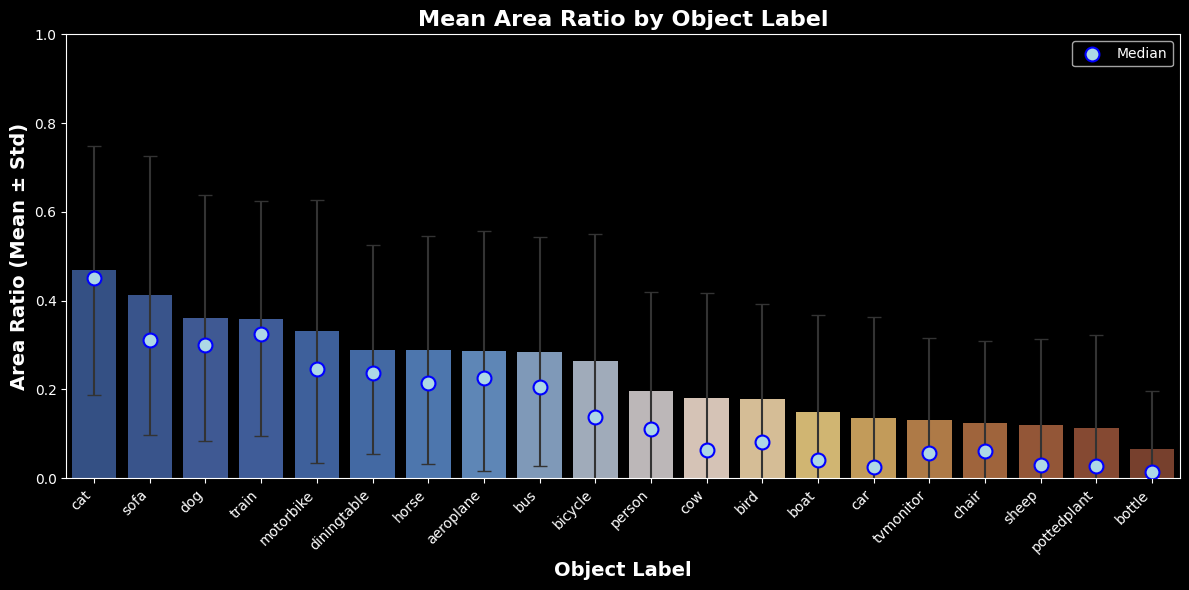

In [5]:
import matplotlib.pyplot as plt
from pypalettes import load_cmap

sorted_stats = label_statistics.sort_values('mean_area_ratio', ascending=False)

cmap = load_cmap('Alacena', cmap_type='continuous', reverse=True)
colors = [cmap(i/len(sorted_stats)) for i in range(len(sorted_stats))]

plt.figure(figsize=(12, 6))

plt.bar(range(len(sorted_stats)), 
        sorted_stats['mean_area_ratio'],
        yerr=sorted_stats['std_area_ratio'],
        ecolor='#333333',
        capsize=5,
        color=colors)

plt.xticks(range(len(sorted_stats)), 
           sorted_stats.index,
           rotation=45,
           ha='right')
plt.xlabel('Object Label', fontsize=14, fontweight='bold')
plt.ylabel('Area Ratio (Mean ± Std)', fontsize=14, fontweight='bold')
plt.title('Mean Area Ratio by Object Label', fontsize=16, fontweight='bold')
plt.scatter(range(len(sorted_stats)), 
           sorted_stats['median_area_ratio'],
           marker='o',
           color='lightblue',
           edgecolor='blue',
           linewidth=1.5,
           s=100,
           zorder=3,
           label='Median')

plt.xlim(-0.5, len(sorted_stats) - 0.5)
plt.ylim(0, 1.0)
plt.legend()


plt.tight_layout()
plt.show()

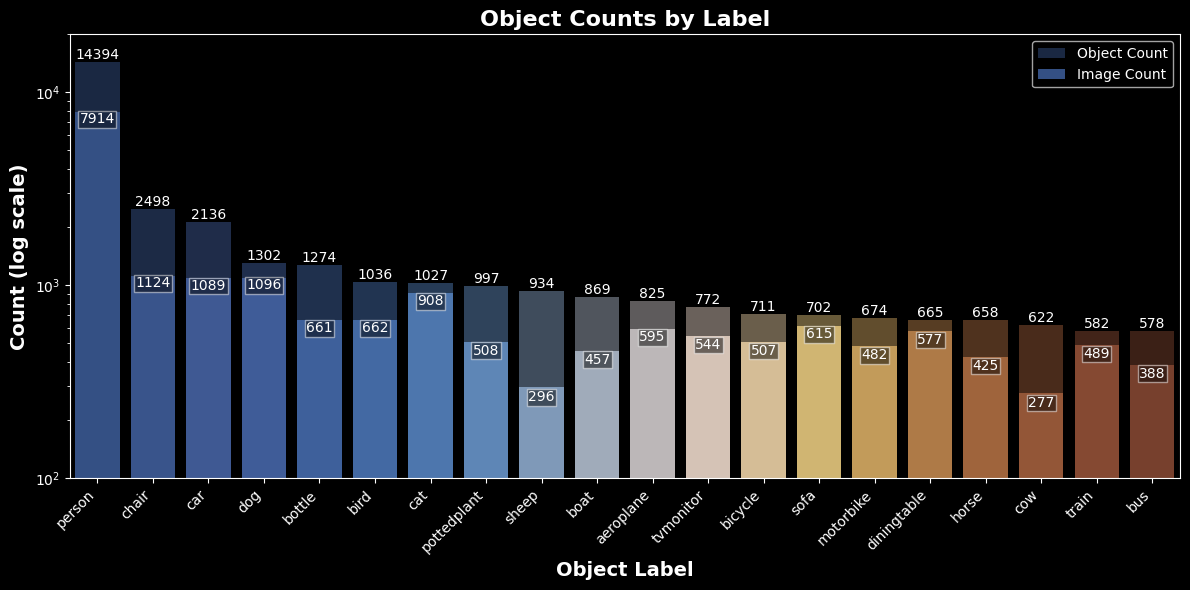

In [6]:
sorted_stats = label_statistics.sort_values('count', ascending=False)

plt.figure(figsize=(12, 6))

bars1 = plt.bar(range(len(sorted_stats)), 
                sorted_stats['count'],
                alpha=0.5,
                color=colors,
                label='Object Count')

bars2 = plt.bar(range(len(sorted_stats)), 
                sorted_stats['image_count'],
                color=colors,
                label='Image Count')

plt.xticks(range(len(sorted_stats)), 
           sorted_stats.index,
           rotation=45,
           ha='right')

plt.xlabel('Object Label', fontsize=14, fontweight='bold')
plt.ylabel('Count (log scale)', fontsize=14, fontweight='bold')
plt.title('Object Counts by Label', fontsize=16, fontweight='bold')

plt.yscale('log')
plt.xlim(-0.5, len(sorted_stats) - 0.5)
plt.ylim(100, 20000)

# Add count labels on top of bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')
    
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 10,
            f'{int(height)}',
            ha='center', va='top', color='white', bbox=dict(facecolor='black', alpha=0.5, pad=1))

plt.legend()
plt.tight_layout()
plt.show()
